Zunächst wird eine Verbindung zu einer SQL Server-Datenbank hergestellt und es werden Aktiendaten für ein spezifisches Unternehmen extrahiert. Zur weiteren Bearbeitung wird eine Transformation der Daten angewandt.

In [1]:
import pyodbc
import yfinance as yf
import pandas as pd
from sqlalchemy import create_engine
import datetime
from datetime import date, timedelta

# Verbindungsstring
conn_str = (
    r'Driver=SQL Server;'
    r'Server=.\SQLEXPRESS;'
    r'Database=studienprojekt;'
    r'Trusted_Connection=yes;'
)

# Verbindung zur Datenbank herstellen
cnxn = pyodbc.connect(conn_str)

# SQLAlchemy connectable erstellen
engine = create_engine('mssql+pyodbc://', creator=lambda: cnxn)

# Tabelle prüfen
# BITTE HIER DATUM UND COMPANY ÄNDERN
table_name = "stock_data"  # Name der Zieltabelle
start_date = "2020-07-01"  # Startdatum, ab dem Daten überprüft werden sollen
end_date = "2023-07-01"  # Enddatum, bis zu dem Daten überprüft werden sollen
company_name = "AAPL"  # nur AAPL, MSFT oder GOOG möglich // Name des Unternehmens, für das Daten geladen werden sollen

# Daten aus der Tabelle für das bestimmte Unternehmen in einen DataFrame laden
select_query = f"SELECT * FROM {table_name} WHERE date >= ? AND date <= ? AND Company = ?"
data = pd.read_sql(select_query, con=engine, params=(start_date, end_date, company_name))

# added
data["ID"] = data.index
data = data[["ID", "Date", "Company", "Type", "Open", "High", "Low", "Close", "Volume"]]
data.reset_index(drop=True, inplace=True)

# Verbindung schließen
cnxn.close()

# DataFrame anzeigen
print(data.tail())


      ID       Date Company Type        Open        High         Low  \
750  750 2023-06-26    AAPL  ACT  186.830002  188.050003  185.229996   
751  751 2023-06-27    AAPL  ACT  185.889999  188.389999  185.669998   
752  752 2023-06-28    AAPL  ACT  187.929993  189.899994  187.600006   
753  753 2023-06-29    AAPL  ACT  189.080002  190.070007  188.940002   
754  754 2023-06-30    AAPL  ACT  191.630005  194.479996  191.259995   

          Close    Volume  
750  185.270004  48088700  
751  188.059998  50730800  
752  189.250000  51216800  
753  189.589996  46347300  
754  193.970001  85069600  


Der historische Kursverlauf der Close-Werte wird in einemLiniendiagramm visualisiert.

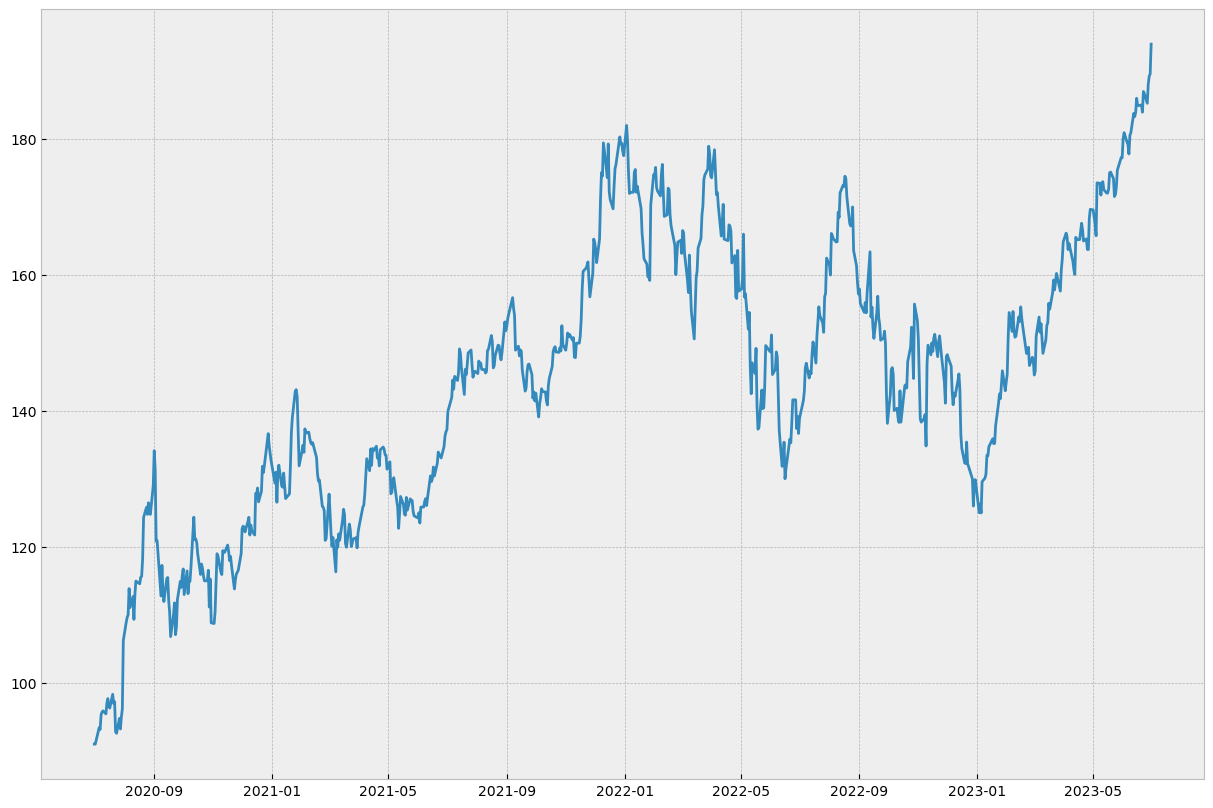

In [2]:
import matplotlib.pyplot as plt
plt.style.use('bmh')
plt.figure(figsize=(15, 10))
plt.plot(data["Date"], data["Close"])

`seasonal_decompose` ist eine Funktion, die eine Zeitreihe in drei verschiedene Komponenten zerlegt:

- Trend: Die zugrundeliegende Tendenz der Zeitreihen. Dabei werden steigende und fallende Tendenzen abgebildet.
- Saisonalität: Periodische Schwankungen. Zum Beispiel könnte der Aktienkurs tendenziell während bestimmter Zeiten eines Jahres steigen oder fallen.
- Residual: Der Teil der Zeitreihe, der nicht durch Trend und Saisonalität erklärt werden kann.

Folgende Parameter werden verwendet:

- `data["Close"]`: Die zu analysierende Zeitreihe der Close-Werte
- `model='multiplicative'`: Das zu verwendende Modell für die Zerlegung. Ein multiplikatives Modell ist geeignet, wenn die Amplitude der saisonalen Schwankungen mit der Zeit zunimmt oder abnimmt.
- `period=30`: Die Länge des saisonalen Zyklus. In diesem Fall wird davon ausgegangen, dass sich die saisonalen Schwankungen alle 30 Tage wiederholen.

<Figure size 640x480 with 0 Axes>

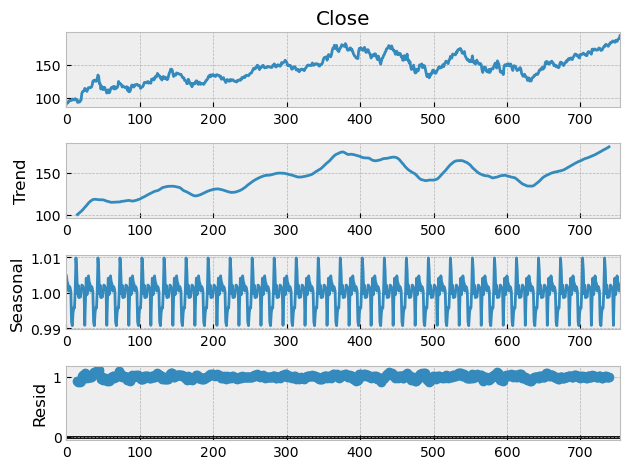

In [3]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(data["Close"], model='multiplicative', period=30)
fig = plt.figure()  
fig = result.plot() 

Die Funktion `pd.plotting.autocorrelation_plot()` ist eine visuelle Hilfsmethode, um die Autokorrelation in einer Zeitreihe darzustellen. Autokorrelation, auch bekannt als serielle Korrelation, bezeichnet die Korrelation eines Elements in einer Serie mit anderen Elementen aus derselben Serie, die von früheren Zeitschritten stammen.

Das Autokorrelationsdiagramm hilft zu erkennen, ob es eine Muster oder eine Beziehung zwischen den Werten einer Zeitspanne gibt und den Werten aus vorherigen Zeitspannen.

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

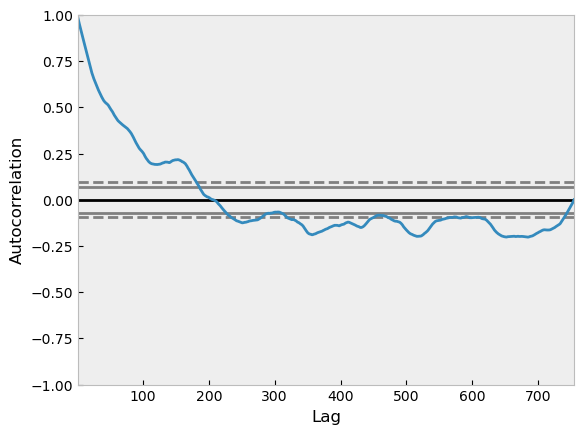

In [4]:
pd.plotting.autocorrelation_plot(data["Close"])

Die Funktion `plot_pacf` aus der `statsmodels.graphics.tsaplots` Bibliothek wird verwendet, um das partielle Autokorrelationsdiagramm für die gegebenen Zeitreihendaten zu erstellen. 

Ein Diagramm der partiellen Autokorrelation gibt Auskunft über die direkte Beziehung eines gegebenen Lags mit der aktuellen Zeitspanne, nachdem die Effekte aller kleineren Lags herausgerechnet wurden. 

Hier sind die Parameter, die in der Funktion verwendet werden:

- `data["Close"]`: Die zu analysierende Zeitreihe (in diesem Fall die Schlusskurse der Aktien).
- `lags=100`: Die Anzahl der Lags, die im Diagramm angezeigt werden sollen. Ein Lag ist eine zeitliche Verzögerung.
- `method='ywm'`: Die Methode zur Schätzung der partiellen Autokorrelation. 'ywm' steht für die Yule-Walker-Gleichungen mit Modifikationen entsprechend der Methode von Levinson-Durbin.

Insgesamt zeigt dieser Codeabschnitt ein Diagramm, das die partielle Autokorrelation der Schlusskurse über 100 Lags hinweg darstellt. Diese Art von Diagramm kann nützlich sein, um die Anzahl der Lags zu bestimmen, die in einem autoregressiven Prognosemodell verwendet werden sollten.

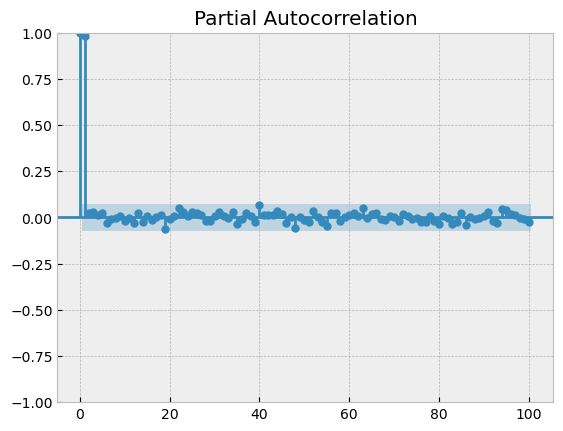

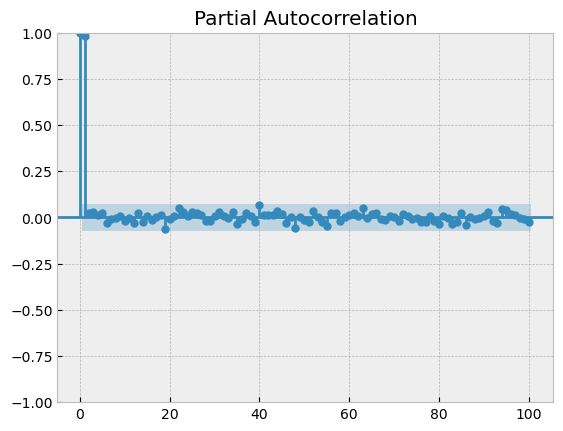

In [5]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(data["Close"], lags=100, method='ywm')

ARIMA ist ein gebräuchlicher Algorithmus für die Vorhersage von Zeitreihen. Er basiert auf drei zentralen Parametern:

- `p` steht für die Anzahl der zurückliegenden Datenpunkte, die berücksichtigt werden, um den nächsten Punkt zu prognostizieren. Dies ist der autoregressive Aspekt des Modells.
- `d` repräsentiert die notwendigen Differenzbildungen, um die Zeitreihe stationär zu machen. Dies ist der integrierte Aspekt des Modells.
- `q` bezieht sich auf die Anzahl der vorhergehenden Fehler, die in das Modell einfließen. Dies ist der gleitende Durchschnittsaspekt des Modells.

In der Funktion `auto_arima` wird das 'Close'-Feld aus unseren Börsendaten als eindimensionales Array übergeben. Die Funktion probiert verschiedene Kombinationen von `p`, `d` und `q` aus und wählt diejenige aus, die das beste Modell ergibt (das heißt, das Modell mit dem niedrigsten AIC-Wert).

Die Einstellung `seasonal=False` teilt dem Modell mit, dass es keine saisonalen Komponenten berücksichtigen soll, während `trace=True` bewirkt, dass der Fortschritt der Funktion während der Ausführung angezeigt wird.

Zum Schluss werden die optimalen Werte für `p`, `d` und `q` ausgegeben und in den entsprechenden Variablen gespeichert.

In [6]:
import pandas as pd
import numpy as np
from pmdarima import auto_arima

# Annahme: Sie haben Ihre Zeitreihendaten in einem DataFrame namens 'data' geladen

# Die Zeitreihendaten in eine eindimensionale NumPy-Array-ähnliche Struktur umwandeln
y = np.array(data['Close'])

# AutoARIMA-Modell erstellen und anpassen, um die optimalen Parameterwerte zu ermitteln
model = auto_arima(y, seasonal=False, trace=True)

# Die optimalen Parameterwerte für P, D und Q ausgeben
print(f"Optimale Werte für P, D und Q: {model.order}")
p, d, q = model.order


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3684.646, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3680.060, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3681.619, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3681.572, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3679.890, Time=0.00 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3682.912, Time=0.18 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.546 seconds
Optimale Werte für P, D und Q: (0, 1, 0)


Es wurden verschiedene Kombinationen von P, D und Q getestet und dabei jeweils den AIC (Akaike Information Criterion) berechnet. Die AIC ist eine Maßzahl für die Güte eines statistischen Modells: Je kleiner der AIC-Wert, desto besser passt das Modell zu den Daten, wenn man die Komplexität des Modells mit einbezieht.

Im gegebenen Fall war das beste Modell ARIMA(0,1,0), weil es den niedrigsten AIC-Wert hatte (3679.890). Die optimalen Werte für P, D und Q waren also 0, 1 und 0. Dies bedeutet:

    P (Ordnung des autoregressiven Teils): 0 – Es werden keine vorherigen Datenpunkte zur Vorhersage des nächsten Punktes verwendet.
    D (Integrationsgrad): 1 – Die Zeitreihe wurde einmal differenziert, um sie stationär zu machen.
    Q (Ordnung des gleitenden Durchschnitts): 0 – Es werden keine vorherigen Fehler in das Modell einbezogen.

In [7]:
#p, d, q = 5, 1, 2
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(data["Close"], order=(p,d,q))
fitted = model.fit()

print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  755
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -1838.945
Date:                Sun, 09 Jul 2023   AIC                           3679.890
Time:                        16:22:27   BIC                           3684.515
Sample:                             0   HQIC                          3681.672
                                - 755                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         7.6903      0.302     25.457      0.000       7.098       8.282
Ljung-Box (L1) (Q):                   0.44   Jarque-Bera (JB):                65.38
Prob(Q):                              0.51   Pr

In [8]:
predictions = fitted.predict()
print(predictions)

0        0.000000
1       91.027496
2       91.027496
3       93.462502
4       93.172501
          ...    
750    186.679993
751    185.270004
752    188.059998
753    189.250000
754    189.589996
Name: predicted_mean, Length: 755, dtype: float64


In [9]:
import statsmodels.api as sm
import warnings
import time

# Startzeit messen
start_time = time.time()

model = sm.tsa.statespace.SARIMAX(data['Close'],
                                 order=(p, d, q),
                                 seasonal_order=(p, d, q, 12))
model = model.fit()

# Endzeit messen
end_time = time.time()

# Gesamtdauer berechnen
duration = end_time - start_time

print(model.summary())
print("Durchlaufdauer:", duration, "Sekunden")

                                     SARIMAX Results                                      
Dep. Variable:                              Close   No. Observations:                  755
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 12)   Log Likelihood               -2084.510
Date:                            Sun, 09 Jul 2023   AIC                           4171.019
Time:                                    16:22:27   BIC                           4175.629
Sample:                                         0   HQIC                          4172.796
                                            - 755                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2        16.1315      0.702     22.973      0.000      14.755      17.508
Ljung-Box (L1) (Q):                

In [10]:
predictions = model.predict(len(data), len(data)+30)
print(predictions)

755    194.610001
756    196.669998
757    195.580002
758    195.669998
759    194.620010
760    197.660004
761    197.339996
762    195.930008
763    198.720001
764    199.910004
765    200.250000
766    204.630005
767    205.270004
768    207.330002
769    206.240005
770    206.330002
771    205.280014
772    208.320007
773    208.000000
774    206.590012
775    209.380005
776    210.570007
777    210.910004
778    215.290009
779    215.930008
780    217.990005
781    216.900009
782    216.990005
783    215.940018
784    218.980011
785    218.660004
Name: predicted_mean, dtype: float64


<Axes: >

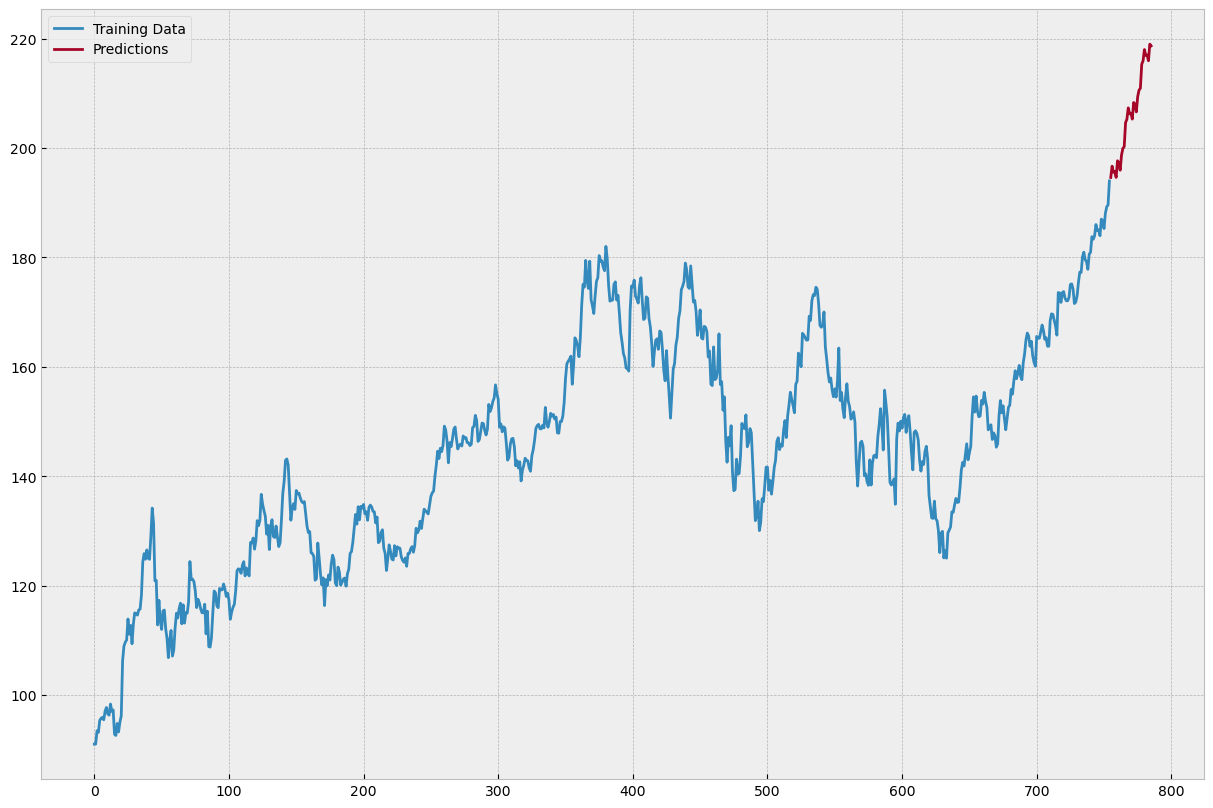

In [11]:
data["Close"].plot(legend=True, label="Training Data", figsize=(15, 10))
predictions.plot(legend=True, label="Predictions")

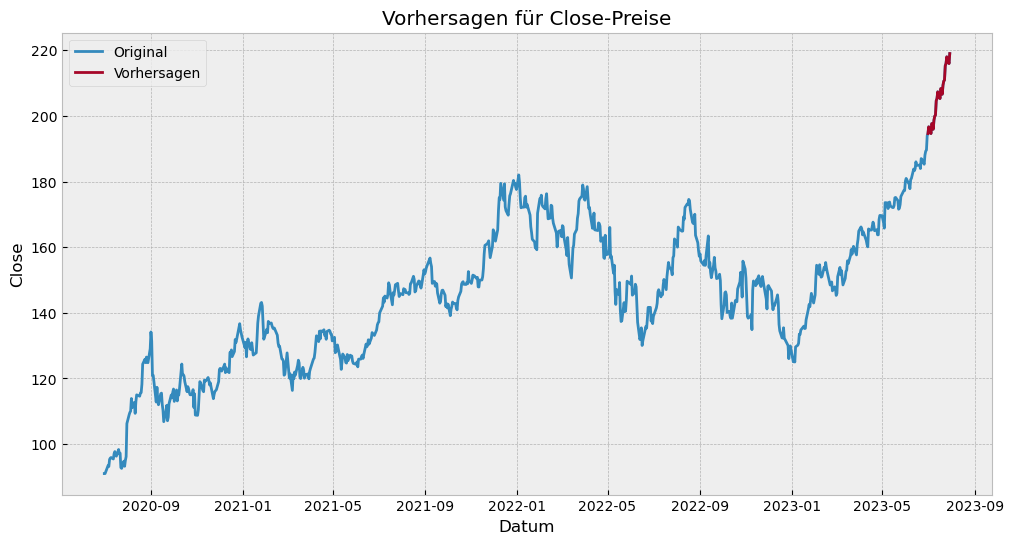

In [12]:
# Vorhersagen für die nächsten 30 Tage erhalten
predictions = model.predict(len(data), len(data) + 29)  # 30 Tage Vorhersagen

# Daten für die nächsten 30 Tage generieren
future_dates = pd.date_range(start=data['Date'].iloc[-1] + timedelta(days=1), periods=30)

# Ein DataFrame für die Vorhersagen erstellen
df_predictions = pd.DataFrame({
    'Date': future_dates,
    'Close': predictions
})

# DataFrame erweitern, indem Sie die Vorhersagen anhängen
data_extended = pd.concat([data, df_predictions])

# Plot erstellen
plt.figure(figsize=(12, 6))
plt.plot(data_extended['Date'], data_extended['Close'], label='Original')
plt.plot(data_extended['Date'].tail(30), data_extended['Close'].tail(30), label='Vorhersagen')
plt.xlabel('Datum')
plt.ylabel('Close')
plt.title('Vorhersagen für Close-Preise')
plt.legend()
plt.grid(True)
plt.show()

In [13]:
data_extended_key = data_extended

In [14]:
data_extended_key

,ID,Date,Company,Type,Open,High,Low,Close,Volume
0,0.0,2020-07-01,AAPL,ACT,91.279999,91.839996,90.977501,91.027496,110737200.0
1,1.0,2020-07-02,AAPL,ACT,91.962502,92.617500,90.910004,91.027496,114041600.0
2,2.0,2020-07-06,AAPL,ACT,92.500000,93.945000,92.467499,93.462502,118655600.0
3,3.0,2020-07-07,AAPL,ACT,93.852501,94.654999,93.057503,93.172501,112424400.0
4,4.0,2020-07-08,AAPL,ACT,94.180000,95.375000,94.089996,95.342499,117092000.0
...,...,...,...,...,...,...,...,...,...
780,NaN,2023-07-26,NaN,NaN,NaN,NaN,NaN,217.990005,NaN
781,NaN,2023-07-27,NaN,NaN,NaN,NaN,NaN,216.900009,NaN
782,NaN,2023-07-28,NaN,NaN,NaN,NaN,NaN,216.990005,NaN
783,NaN,2023-07-29,NaN,NaN,NaN,NaN,NaN,215.940018,NaN


In [15]:
import numpy as np

# Key einbinden
company = data.loc[0]['Company']
data_extended_key['Company'] = company
data_extended_key['Type'] = data_extended_key['High'].apply(lambda x: f'Arima_{company}' if np.isnan(x) else f'Act_{company}')
data_extended_key.loc[data_extended_key['Type'].str.contains('Arima'), 'Forecast_Date'] = end_date
data_extended_key['Key'] = data_extended_key['Company'] + '_' + data_extended_key['Date'].astype(str) + '_' + data_extended_key['Type']


In [16]:
import pyodbc
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import warnings

# Deaktivieren der Pandas-Warnungen
warnings.filterwarnings('ignore', category=UserWarning)

# Verbindungsstring
conn_str = (
    r'Driver=SQL Server;'
    r'Server=.\SQLEXPRESS;'
    r'Database=studienprojekt;'
    r'Trusted_Connection=yes;'
)

# Verbindung zur Datenbank herstellen
cnxn = pyodbc.connect(conn_str)

# SQLAlchemy connectable erstellen
engine = create_engine('mssql+pyodbc://', creator=lambda: cnxn)

# Query erstellen, um alle Daten auszulesen
query = "SELECT * FROM stock_data_forecast"

# Ausführen der Query und Laden der Ergebnisse in einen DataFrame
exists_df = pd.read_sql(query, cnxn)

# added
exists_df = exists_df.astype(data_extended.dtypes)
exists_df = exists_df.reindex(columns=data_extended.columns)

# Key einbinden
exists_df['Key'] = exists_df['Company'] + '_' + exists_df['Date'].astype(str) + '_' + exists_df['Type']

In [17]:
# Zusammenführen der beiden DataFrames
combined_df = pd.concat([exists_df, data_extended_key])



In [18]:
# Entfernen von Duplikaten
combined_df = combined_df.drop_duplicates(subset=['Key'], keep=False)

In [19]:
# Schreiben des aktualisierten DataFrames in die SQL Server-Tabelle
combined_df.to_sql('stock_data_forecast', con=engine, if_exists='append', index=False)

# Anzahl der geschriebenen Zeilen erhalten
num_written_rows = combined_df.shape[0]
print(f"Es wurden {num_written_rows} Zeilen erfolgreich übertragen.")

exists_df = pd.read_sql('SELECT * FROM stock_data_forecast', cnxn)
exists_df.drop_duplicates(subset='Key', inplace=True)

# Verbindung schließen
cnxn.close()
print(f"Die Verbindung ist wieder geschlossen.")

Es wurden 78 Zeilen erfolgreich übertragen.
Die Verbindung ist wieder geschlossen.


In [20]:
combined_df

,ID,Date,Company,Type,Open,High,Low,Close,Volume,Forecast_Date,Key
880,NaN,2023-06-02,AAPL,Arima_AAPL,NaN,NaN,NaN,180.089996,NaN,2023-06-01,AAPL_2023-06-02_Arima_AAPL
881,NaN,2023-06-03,AAPL,Arima_AAPL,NaN,NaN,NaN,180.709991,NaN,2023-06-01,AAPL_2023-06-03_Arima_AAPL
882,NaN,2023-06-04,AAPL,Arima_AAPL,NaN,NaN,NaN,183.069992,NaN,2023-06-01,AAPL_2023-06-04_Arima_AAPL
883,NaN,2023-06-05,AAPL,Arima_AAPL,NaN,NaN,NaN,183.179993,NaN,2023-06-01,AAPL_2023-06-05_Arima_AAPL
884,NaN,2023-06-06,AAPL,Arima_AAPL,NaN,NaN,NaN,182.219986,NaN,2023-06-01,AAPL_2023-06-06_Arima_AAPL
...,...,...,...,...,...,...,...,...,...,...,...
780,NaN,2023-07-26,AAPL,Arima_AAPL,NaN,NaN,NaN,217.990005,NaN,2023-07-01,AAPL_2023-07-26_Arima_AAPL
781,NaN,2023-07-27,AAPL,Arima_AAPL,NaN,NaN,NaN,216.900009,NaN,2023-07-01,AAPL_2023-07-27_Arima_AAPL
782,NaN,2023-07-28,AAPL,Arima_AAPL,NaN,NaN,NaN,216.990005,NaN,2023-07-01,AAPL_2023-07-28_Arima_AAPL
783,NaN,2023-07-29,AAPL,Arima_AAPL,NaN,NaN,NaN,215.940018,NaN,2023-07-01,AAPL_2023-07-29_Arima_AAPL
